# Modele z wieloklasowym wyjściem 

Zbiór danych: https://www.kaggle.com/datasets/abdullah0a/human-age-prediction-synthetic-dataset

Cel biznesowy: Na podstawie charakterystyk pacjenta wyznacz stan zdrowia (poziom cholesterolu, glukozy we krwi i gęstość kości)

Nasz problem ma 3 zmienne objaśniane. Możemy stworzyć 3 osobne modele lub 1 wspólny.

In [1]:
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor,  RegressorChain
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# puść ten kod, 
# jeżeli wywołujesz plik  w folderze rozwiąznaia, 
# a ramka danych znajduje się w folderze data
import os 
os.chdir('../')

In [3]:
# Wczytanie danych
train = pd.read_csv("data/Train.csv")
test = pd.read_csv("data/Test.csv")

In [3]:
# info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       3000 non-null   object 
 1   Height (cm)                  3000 non-null   float64
 2   Weight (kg)                  3000 non-null   float64
 3   Blood Pressure (s/d)         3000 non-null   object 
 4   Cholesterol Level (mg/dL)    3000 non-null   float64
 5   BMI                          3000 non-null   float64
 6   Blood Glucose Level (mg/dL)  3000 non-null   float64
 7   Bone Density (g/cm²)         3000 non-null   float64
 8   Vision Sharpness             3000 non-null   float64
 9   Hearing Ability (dB)         3000 non-null   float64
 10  Physical Activity Level      3000 non-null   object 
 11  Smoking Status               3000 non-null   object 
 12  Alcohol Consumption          1799 non-null   object 
 13  Diet              

In [4]:
train.head()

,Gender,Height (cm),Weight (kg),Blood Pressure (s/d),Cholesterol Level (mg/dL),BMI,Blood Glucose Level (mg/dL),Bone Density (g/cm²),Vision Sharpness,Hearing Ability (dB),...,Family History,Cognitive Function,Mental Health Status,Sleep Patterns,Stress Levels,Pollution Exposure,Sun Exposure,Education Level,Income Level,Age (years)
0,Male,171.148359,86.185197,151/109,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,...,NaN,44.059172,Good,Insomnia,2.797064,5.142344,7.108975,NaN,Medium,89
1,Male,172.946206,79.641937,134/112,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,...,Heart Disease,45.312298,Good,Normal,9.339930,7.272720,3.918489,Undergraduate,Medium,77
2,Female,155.945488,49.167058,160/101,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,...,Hypertension,56.246991,Poor,Insomnia,9.234637,8.500386,5.393408,NaN,Medium,70
3,Female,169.078298,56.017921,133/94,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,...,Hypertension,55.196092,Poor,Insomnia,4.693446,7.555511,2.745578,NaN,Low,52
4,Female,163.758355,73.966304,170/106,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,...,NaN,53.023379,Good,Normal,4.038537,9.429097,3.878435,Undergraduate,High,79


In [5]:
train.select_dtypes(include='object').head()

,Gender,Blood Pressure (s/d),Physical Activity Level,Smoking Status,Alcohol Consumption,Diet,Chronic Diseases,Medication Use,Family History,Mental Health Status,Sleep Patterns,Education Level,Income Level
0,Male,151/109,Moderate,Former,NaN,Low-carb,NaN,NaN,NaN,Good,Insomnia,NaN,Medium
1,Male,134/112,Low,Current,Occasional,Balanced,Hypertension,NaN,Heart Disease,Good,Normal,Undergraduate,Medium
2,Female,160/101,Moderate,Never,NaN,Balanced,Hypertension,Regular,Hypertension,Poor,Insomnia,NaN,Medium
3,Female,133/94,Moderate,Never,NaN,Balanced,Diabetes,Occasional,Hypertension,Poor,Insomnia,NaN,Low
4,Female,170/106,Low,Former,Frequent,Vegetarian,NaN,NaN,NaN,Good,Normal,Undergraduate,High


In [6]:
# Uzupełnienie braków danych
train = train.fillna('unknown')

In [7]:
test = test.fillna('unknown')

In [8]:
# korelacja
train.select_dtypes(exclude='object').corr()

,Height (cm),Weight (kg),Cholesterol Level (mg/dL),BMI,Blood Glucose Level (mg/dL),Bone Density (g/cm²),Vision Sharpness,Hearing Ability (dB),Cognitive Function,Stress Levels,Pollution Exposure,Sun Exposure,Age (years)
Height (cm),1.000000,0.398371,-0.027233,-0.222789,0.011990,-0.023558,-0.009272,0.009461,0.018231,-0.006537,-0.028681,0.001900,0.020322
Weight (kg),0.398371,1.000000,0.041859,0.800150,0.015960,-0.008140,0.000436,0.008944,0.006220,0.016620,-0.029717,-0.013118,0.002521
Cholesterol Level (mg/dL),-0.027233,0.041859,1.000000,0.065532,0.189589,-0.401220,-0.382170,0.328465,-0.230204,0.001813,0.001632,0.009417,0.432368
BMI,-0.222789,0.800150,0.065532,1.000000,0.012700,0.003840,0.003684,0.005878,-0.006549,0.021403,-0.009308,-0.014736,-0.008042
Blood Glucose Level (mg/dL),0.011990,0.015960,0.189589,0.012700,1.000000,-0.393006,-0.396912,0.311569,-0.209052,-0.021140,-0.004916,0.021439,0.428573
Bone Density (g/cm²),-0.023558,-0.008140,-0.401220,0.003840,-0.393006,1.000000,0.846140,-0.667803,0.475936,-0.033976,0.013555,-0.003921,-0.937712
Vision Sharpness,-0.009272,0.000436,-0.382170,0.003684,-0.396912,0.846140,1.000000,-0.639199,0.466071,-0.023664,0.003519,-0.011532,-0.899692
Hearing Ability (dB),0.009461,0.008944,0.328465,0.005878,0.311569,-0.667803,-0.639199,1.000000,-0.384928,0.027843,-0.013024,0.019801,0.712374
Cognitive Function,0.018231,0.006220,-0.230204,-0.006549,-0.209052,0.475936,0.466071,-0.384928,1.000000,-0.040382,-0.011985,-0.004089,-0.508058
Stress Levels,-0.006537,0.016620,0.001813,0.021403,-0.021140,-0.033976,-0.023664,0.027843,-0.040382,1.000000,0.025995,0.020434,0.029093


In [9]:
# nazwy zmiennych y 
y_names = ['Cholesterol Level (mg/dL)','Blood Glucose Level (mg/dL)','Bone Density (g/cm²)']

In [10]:
# korelacja zmiennych y
train.select_dtypes(exclude = 'object').corr()[y_names]

,Cholesterol Level (mg/dL),Blood Glucose Level (mg/dL),Bone Density (g/cm²)
Height (cm),-0.027233,0.011990,-0.023558
Weight (kg),0.041859,0.015960,-0.008140
Cholesterol Level (mg/dL),1.000000,0.189589,-0.401220
BMI,0.065532,0.012700,0.003840
Blood Glucose Level (mg/dL),0.189589,1.000000,-0.393006
Bone Density (g/cm²),-0.401220,-0.393006,1.000000
Vision Sharpness,-0.382170,-0.396912,0.846140
Hearing Ability (dB),0.328465,0.311569,-0.667803
Cognitive Function,-0.230204,-0.209052,0.475936
Stress Levels,0.001813,-0.021140,-0.033976


In [14]:
cat_names = ['Smoking Status',	'Alcohol Consumption',	'Diet']

In [15]:
train[[cat_names[0]] + y_names].groupby(cat_names[0]).describe()

Cholesterol Level (mg/dL)                                     \
                                   count        mean        std         min   
Smoking Status                                                                
Current                            793.0  235.017721  23.568927  162.791040   
Former                            1181.0  235.715661  24.675473  164.078306   
Never                             1026.0  231.325667  24.855474  148.811514   

                                                                \
                       25%         50%         75%         max   
Smoking Status                                                   
Current         218.428149  235.182961  251.092372  331.300589   
Former          218.999974  236.119899  252.675166  307.920410   
Never           213.872964  231.539665  248.249177  303.124656   

               Blood Glucose Level (mg/dL)              ...              \
                                     count        mean  ...         75%   
Smoking Status                                          ...               
Current                              793.0  127.483424  ...  139.982435   
Former                              1181.0  128.008141  ...  140.180727   
Never                               1026.0  124.453954  ...  136.596616   

                           Bone Density (g/cm²)                                \
                       max                count      mean       std       min   
Smoking Status                                                                  
Current         184.993757                793.0  0.856668  0.414568 -0.219787   
Former          185.736144               1181.0  0.888083  0.428320 -0.101387   
Never           180.904420               1026.0  1.040480  0.461770 -0.116675   

                                                        
                     25%       50%       75%       max  
Smoking Status                                          
Current         0.534254  0.857510  1.176457  1.878162  
Former          0.534522  0.897031  1.227009  1.999829  
Never           0.667853  1.087685  1.433248  1.998231  

[3 rows x 24 columns]

In [16]:
train[[cat_names[1]] + y_names].groupby(cat_names[1]).describe()

Cholesterol Level (mg/dL)                         \
                                        count        mean        std   
Alcohol Consumption                                                    
Frequent                                742.0  233.702845  24.204052   
Occasional                             1057.0  234.338016  25.021932   
unknown                                1201.0  233.960524  24.287386   

                                                                     \
                            min         25%         50%         75%   
Alcohol Consumption                                                   
Frequent             162.791040  216.028523  234.039504  249.627589   
Occasional           148.811514  217.002638  234.615015  251.562629   
unknown              164.078306  216.842177  234.459685  250.835350   

                                Blood Glucose Level (mg/dL)              ...  \
                            max                       count        mean  ...   
Alcohol Consumption                                                      ...   
Frequent             331.300589                       742.0  126.533375  ...   
Occasional           313.102934                      1057.0  127.041565  ...   
unknown              312.360851                      1201.0  126.387200  ...   

                                            Bone Density (g/cm²)            \
                            75%         max                count      mean   
Alcohol Consumption                                                          
Frequent             138.909458  185.736144                742.0  0.953206   
Occasional           138.877182  184.993757               1057.0  0.913719   
unknown              139.932498  182.615206               1201.0  0.934735   

                                                                       \
                          std       min       25%       50%       75%   
Alcohol Consumption                                                     
Frequent             0.452849 -0.116675  0.581421  0.976295  1.312946   
Occasional           0.435275 -0.219787  0.558219  0.919076  1.277087   
unknown              0.444675 -0.042009  0.553870  0.939595  1.295191   

                               
                          max  
Alcohol Consumption            
Frequent             1.998231  
Occasional           1.890632  
unknown              1.999829  

[3 rows x 24 columns]

In [17]:
train[[cat_names[2]] + y_names].groupby(cat_names[2]).describe()

Cholesterol Level (mg/dL)                                     \
                               count        mean        std         min   
Diet                                                                      
Balanced                      1183.0  233.020391  24.809506  162.791040   
High-fat                       662.0  234.475057  25.182760  164.537785   
Low-carb                       605.0  235.078111  23.239114  148.811514   
Vegetarian                     550.0  234.511846  24.452316  169.583001   

                                                            \
                   25%         50%         75%         max   
Diet                                                         
Balanced    216.231018  233.295648  250.100751  331.300589   
High-fat    217.030305  234.298871  250.752503  303.124656   
Low-carb    218.677810  235.738205  251.477212  304.631578   
Vegetarian  216.325408  234.744187  251.087495  307.459757   

           Blood Glucose Level (mg/dL)              ...              \
                                 count        mean  ...         75%   
Diet                                                ...               
Balanced                        1183.0  126.547935  ...  138.714232   
High-fat                         662.0  127.200686  ...  140.076092   
Low-carb                         605.0  126.410358  ...  139.371351   
Vegetarian                       550.0  126.491633  ...  139.162053   

                       Bone Density (g/cm²)                                \
                   max                count      mean       std       min   
Diet                                                                        
Balanced    182.615206               1183.0  0.945507  0.431260 -0.116675   
High-fat    185.736144                662.0  0.906486  0.447030 -0.076554   
Low-carb    171.331415                605.0  0.931123  0.446722 -0.105823   
Vegetarian  184.993757                550.0  0.934072  0.461450 -0.219787   

                                                    
                 25%       50%       75%       max  
Diet                                                
Balanced    0.590737  0.963305  1.285482  1.999829  
High-fat    0.529195  0.896328  1.274460  1.928408  
Low-carb    0.546224  0.955598  1.312134  1.998231  
Vegetarian  0.550846  0.919037  1.331401  1.890632  

[4 rows x 24 columns]

In [21]:
oe = OrdinalEncoder().fit(train[[cat_names[0]]])

In [22]:
train['smoking_encoded'] = oe.transform(train[[cat_names[0]]])

In [23]:
test['smoking_encoded'] = oe.transform(test[[cat_names[0]]])

In [29]:
#zmienne X
x_names = [ 'Cognitive Function','Hearing Ability (dB)','Vision Sharpness','smoking_encoded']

In [30]:
#model bazowy
base_model = DecisionTreeRegressor(max_depth=15, min_samples_leaf=10, min_samples_split=20)

In [31]:
# Model multi output
model_1 = MultiOutputRegressor(base_model).fit(train[x_names], train[y_names])

In [32]:
# r^2 train
model_1.score(train[x_names],train[y_names])

0.5294167200507482

In [33]:
# r^2 test
model_1.score(test[x_names],test[y_names])

0.5294167200507481

In [34]:
# Chain regressor
model_2 = RegressorChain(base_model).fit(train[x_names],train[y_names])

In [35]:
# r^2 train
model_2.score(train[x_names],train[y_names])

0.4540697209042121

In [36]:
# r^2 test
model_2.score(test[x_names],test[y_names])

0.4540697209042121

In [37]:
# predykcje
model_2.predict(train[x_names])

array([[2.59048291e+02, 1.39675072e+02, 1.75816819e-01],
       [2.31604673e+02, 1.50658147e+02, 4.55831931e-01],
       [2.30821995e+02, 1.43469916e+02, 4.59713168e-01],
       ...,
       [2.29933593e+02, 1.24842957e+02, 4.20433044e-01],
       [2.33532545e+02, 1.22290640e+02, 1.22138772e+00],
       [2.42288234e+02, 1.26900718e+02, 1.21443147e+00]])

In [38]:
y_names

['Cholesterol Level (mg/dL)',
 'Blood Glucose Level (mg/dL)',
 'Bone Density (g/cm²)']

In [41]:
# chain regressor - zmiana kolejności
model_3 = RegressorChain(base_model, order=[1,0,2]).fit(train[x_names], train[y_names])

In [42]:
# r^2 test
model_3.score(test[x_names], test[y_names])

0.4581657424587238

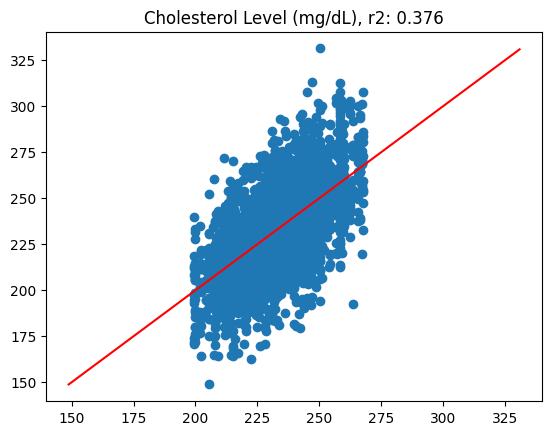

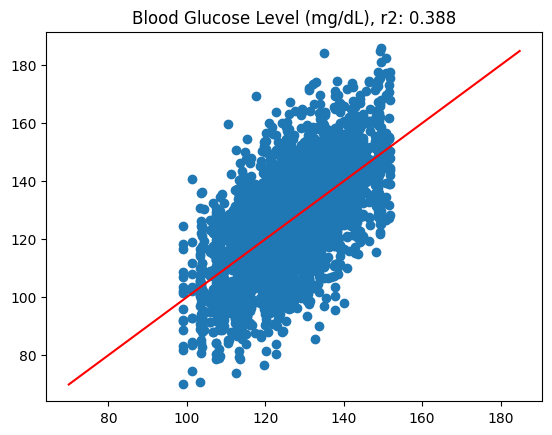

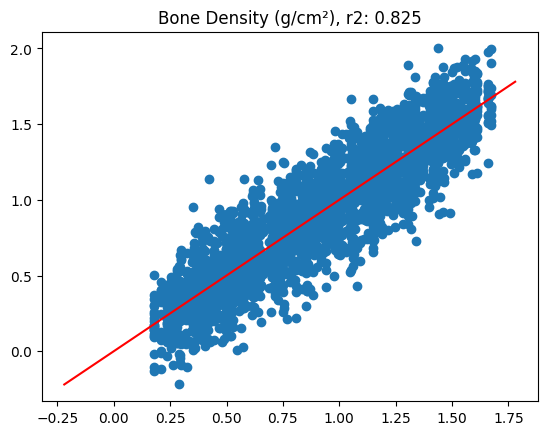

In [43]:
# wizualizacja
preds = model_1.predict(test[x_names])
for i in range(3):
    min_val = np.min((model_1.predict(test[x_names])[:,i].min(),test[y_names[i]].min()))
    max_val = np.max((model_1.predict(test[x_names])[:,i].max(),test[y_names[i]].max()))
    pred_i = preds[:,i]
    r2 = np.round(r2_score(test[y_names[i]], pred_i),3)
    plt.scatter(pred_i,test[y_names[i]])
    plt.plot(np.arange(min_val, max_val),np.arange(min_val,max_val),color='red')
    plt.title(f'{y_names[i]}, r2: {r2}')    
    plt.show()